In [1]:
import serial
import numpy as np

## MPB Communications AMP DAQ Class

In [2]:
class MPB:
    def __init__(self, COM_port):
        self.ser = serial.Serial('COM1', 9600, parity=serial.PARITY_NONE, stopbits = 1,
                    xonxoff = 0, timeout = 0.5, bytesize = 8)
        
    def read(self):
        stop = b'\rD >'
        ret = b''
        while True:
            b = self.ser.read(1)
            if b == b'\r':
                self.ser.read(3)
                break
            else:
                ret += b
        return ret.decode()

    def command(self, command):
        self.ser.write(str.encode(command+'\r'))
        return self.read()
    
    def GetModel(self):
        return self.command("GETMODEL")
    
    def LaserState(self, laser = 0):
        return self.command(f"LASERSTATE {laser}")
    
    def Power(self, point = 3):
        return self.command(f"POWER {point}")
    
    def GetLDEnable(self):
        return self.command('getLDenable')
    
    def GetPower(self, point = 0):
        return self.command(f'GETPOWER {point}')
    
    def GetMode(self):
        return self.command('GETMODE')
    
    def GetState(self):
        return self.command('GETSTATE')
    
    def GetOut(self):
        return self.command('GETOUT')
    
    def GetLaserState(self):
        return self.command('GETLASERSTATE')

    def GetLaserStateSym(self, value = 0):
        """
        Returns the strings corresponding to the laserstate integer returns.
        Note that param value does not correspond to the integer returned by
        GetLaserState, need to loop through value 0 to 17 to get all
        corresponding codes.
        E.g. 0 -> OFF
             6 -> KEYLOCK
             7 -> INTERLOCK
        """
        return self.command(f'GETLASERSTATESYM {value}')

    def GetPowerEnable(self):
        return self.command('GETPOWERENABLE')
    
    def GetFault(self):
        """
        Get faults, returns 5 bits
        1   SHG temperature
        2   TEC temperature
        3   Laser diode current
        4   Watchdog timeout
        5   Case temperature
        """
        return self.command('GETFLT')

    def GetAlarm(self):
        """
        Get alarms, returns 5 bits
        1   SHG temperature
        2   TEC temperature
        3   Pump bias
        4   Loss of output
        5   Case temperature
        """
        return self.command('GETALR')
    
    def SetEnv(self, env = 0):
        return self.command(f'SETENV {env}')
    
    def EnterTestEnvironment(self):
        return self.command('testeoa')+self.read()+self.read()
    
    def SetSHGTemperature(self, temperature = 50.7):
        return self.command(f'SETTECSETPT 4 {temperature}')

    def GetSHGSetpoint(self):
        return self.command('GETTECSETPT 4')
    
    def SetLDEnable(self, on = 0):
        """
        Enabling the MBP amplifier
        """
        return self.command(f'setLDenable {on}')

    def GetLDCurrent(self, ld = 0):
        """
        Returns the LD {ld} current setpoint
        """
        return self.command(f'GETLDCURRENT {ld}')

    def SetLDCurrent(self, ld = 3, current = 1000):
        """
        Set the LD {ld} current setpoint
        """
        return self.command(f'SETLDCURRENT {ld} {current}')

    def LDCurrent(self, ld = 3):
        """
        Returns the actual LD {ld} current
        """
        return self.command(f'LDCURRENT {ld}')

    def PowerEnable(self, enable = 0):
        """
        Set the amplifier to ACC or APC mode
        0   ACC
        1   APC
        """
        return self.command(f'POWERENABLE {enable}')

    def SetPower(self, point = 0, value = 400):
        """
        point 0 sets the SHG output power setpoint
        """
        return self.command(f'SETPOWER {point} {value}')
    
    def GetSHGTemperature(self):
        return self.command('TECTEMP 4')

## HDF helper functions

In [3]:
import h5py

def create_hdf_grp(fname, grp_name, attrs):
    with h5py.File(fname, 'a') as f:
        grp = f.create_group(grp_name)
        for k,v in attrs.items():
            grp.attrs[k] = v

def create_hdf_dset(fname, grp_name, dset_name, dtype, attrs):
    with h5py.File(fname, 'a') as f:
        grp = f[grp_name]
        dset = grp.create_dataset(dset_name, (0,), dtype = dtype, maxshape = (None,))
        for k,v in attrs.items():
            dset.attrs[k] = v 

def save_to_hdf(fname, grp_name, dset_name, data, dtype):
    with h5py.File(fname, 'a') as f:
        dset = f[grp_name][dset_name]
        for d in data:
            dset.resize(dset.shape[0]+d.shape[1], axis = 0)
            dk = np.array([tuple(di) for di in d.T], dtype = dtype)
            dset[-d.shape[1]:] = dk

## Continuous DAQ Readout Function

In [4]:
from ctypes import *
from PyDAQmx.DAQmxTypes import *
from PyDAQmx import *
import PyDAQmx

def read_daq_continuous(rate, nrsamples, channels):
    # Declaration of variable passed by reference
    taskHandle = TaskHandle()
    read = int32()

    # DAQmx Configure Code
    DAQmxCreateTask("",byref(taskHandle))
    DAQmxCreateAIVoltageChan(taskHandle,"Dev1/ai1, Dev1/ai3","",DAQmx_Val_Cfg_Default,-1,5,DAQmx_Val_Volts,None)
    DAQmxCfgSampClkTiming(taskHandle,"",rate,DAQmx_Val_Rising,DAQmx_Val_ContSamps,nrsamples)
    return taskHandle

# Measurement 1
- s polarization PDA10A2 photodiode with 0.6 ND filter
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
10 minute measurement

In [72]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 1'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "polarizing beamsplitter after fiber of MPB amp\n"+\
              "s polarization : PDA10A2 with 0.6 ND filter\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = 60*10

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [10:00<00:00,  1.00it/s]


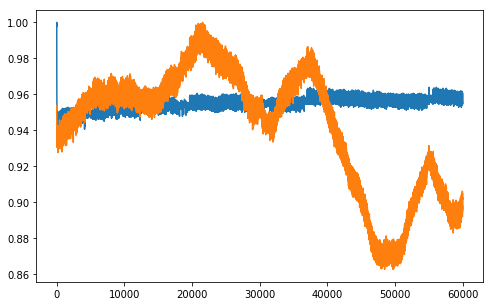

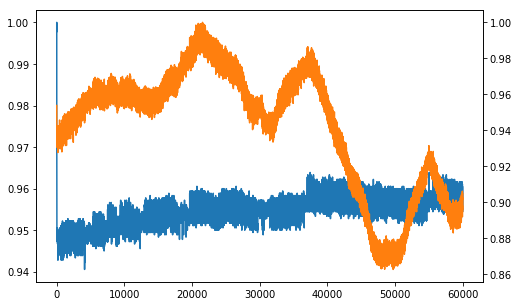

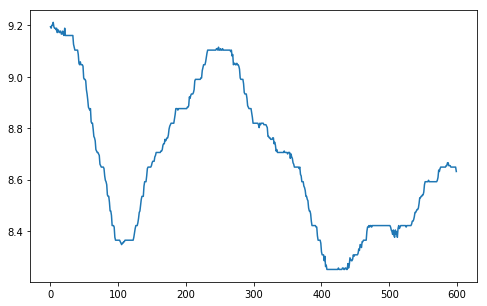

In [88]:
import matplotlib.pyplot as plt
with h5py.File(fname, 'r') as f:
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value

p = ni['p polarization']
s = ni['s polarization']
p /= p.max()
s /= s.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(p)
ax.plot(s)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(ni['p polarization'])
ax1 = ax.twinx()
ax1.plot(ni['s polarization'], 'C1')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(mpb['seed power'])

# Measurement 2
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
$\lambda$/2 plate to get equal power in both arms
10 minute measurement

In [93]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 2'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "half wave plate before polarizing beamsplitter after fiber of MPB amp to get equal power in both paths\n"+\
              "fiber -> lambda/2 -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = 60*10

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [10:00<00:00,  1.01it/s]


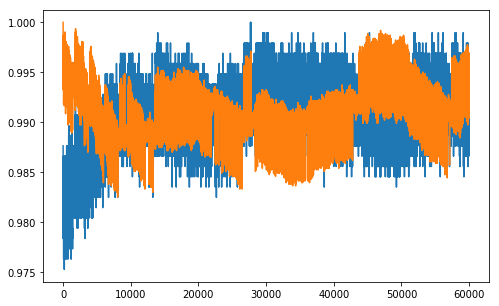

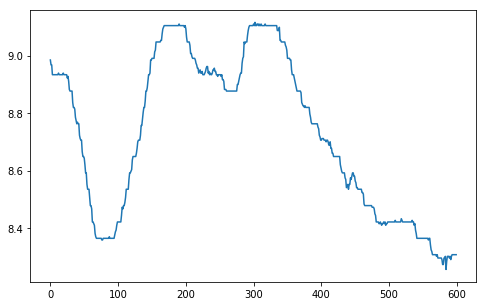

In [100]:
import matplotlib.pyplot as plt

with h5py.File(fname, 'r') as f:
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value

p = ni['p polarization'][20:]
s = ni['s polarization'][20:]
p /= p.max()
s /= s.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(p)
ax.plot(s)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(mpb['seed power'])

# Measurement 3
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
$\lambda$/2 plate to get equal power in both arms
30 minute measurement

In [101]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 3'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "half wave plate before polarizing beamsplitter after fiber of MPB amp to get equal power in both paths\n"+\
              "fiber -> lambda/2 -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = 60*30

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [30:00<00:00,  1.00it/s]


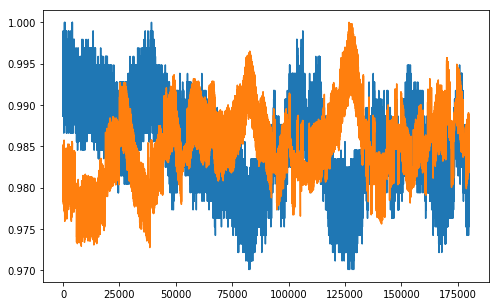

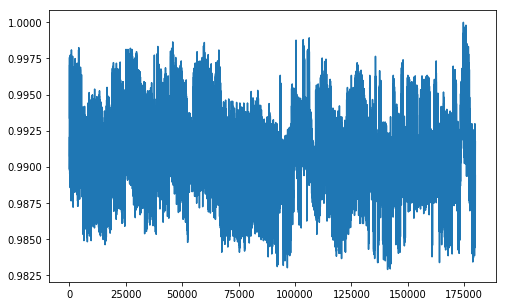

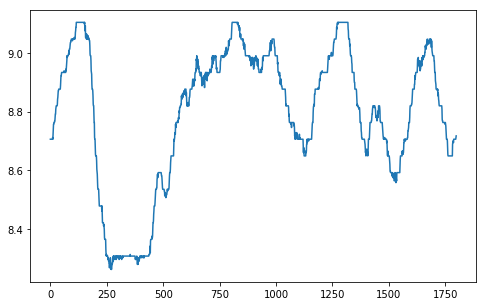

In [104]:
import matplotlib.pyplot as plt

with h5py.File(fname, 'r') as f:
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value

p = ni['p polarization'][20:]
s = ni['s polarization'][20:]
p /= p.max()
s /= s.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(p)
ax.plot(s)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot((p+s)/(p+s).max())

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(mpb['seed power'])

# Measurement 4
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
$\lambda$/2 plate to get equal power in both arms
4 hour measurement

In [105]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 4'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "half wave plate before polarizing beamsplitter after fiber of MPB amp to get equal power in both paths\n"+\
              "fiber -> lambda/2 -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*60*4)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

 41%|██████████████████████████████▏                                          | 5960/14400 [1:39:20<2:20:32,  1.00it/s]

InvalidTaskError: Task specified is invalid or does not exist.
Status Code: -200088
 in function DAQmxStopTask

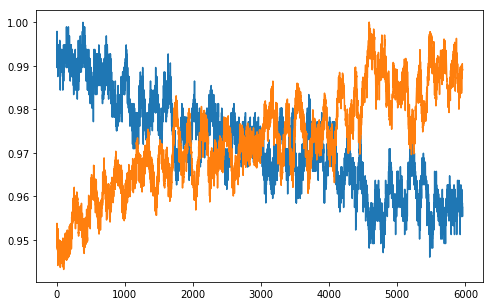

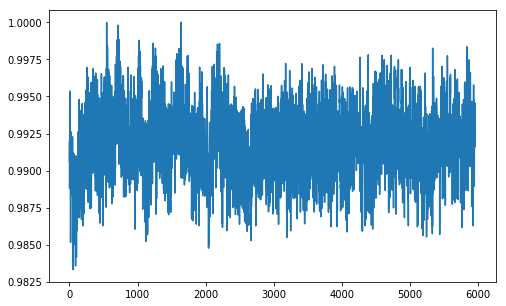

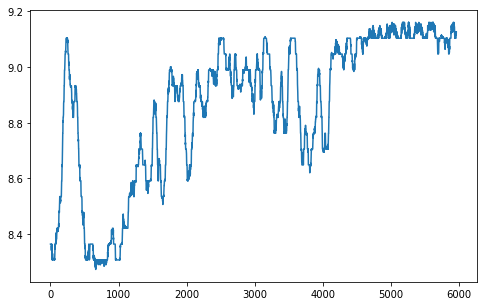

In [110]:
import matplotlib.pyplot as plt

with h5py.File(fname, 'r') as f:
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value

p = ni['p polarization'][20:][::100]
s = ni['s polarization'][20:][::100]
p /= p.max()
s /= s.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(p)
ax.plot(s)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot((p+s)/(p+s).max())

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(mpb['seed power'])

# Measurement 5
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
$\lambda$/2 plate to get equal power in both arms
120 second measurement

In [113]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 5'
description = "Test Measurement, blocking s and then p sensors.\n"+\
              "half wave plate before polarizing beamsplitter after fiber of MPB amp to get equal power in both paths\n"+\
              "fiber -> lambda/2 -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(120)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [02:00<00:00,  1.00s/it]


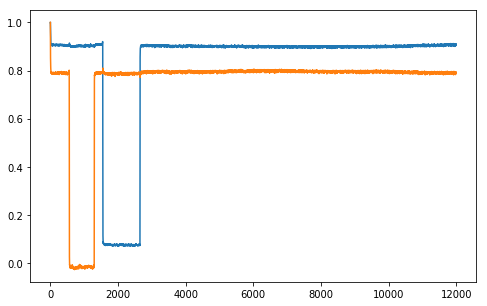

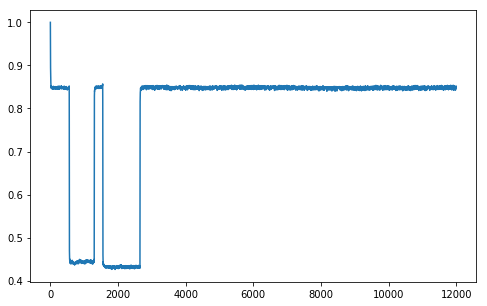

In [114]:
import matplotlib.pyplot as plt

with h5py.File(fname, 'r') as f:
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value

p = ni['p polarization'][:]
s = ni['s polarization'][:]
p /= p.max()
s /= s.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(p)
ax.plot(s)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot((p+s)/(p+s).max())

# Measurement 6
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
$\lambda$/2 plate to get equal power in both arms
6 hour measurement

In [5]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 6'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "half wave plate before polarizing beamsplitter after fiber of MPB amp to get equal power in both paths\n"+\
              "fiber -> lambda/2 -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*60*6)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

100%|██████████████████████████████████████████████████████████████████████████| 21600/21600 [6:00:00<00:00,  1.00s/it]


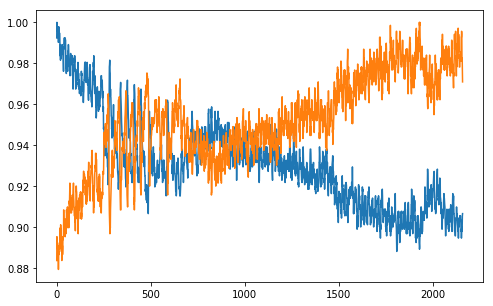

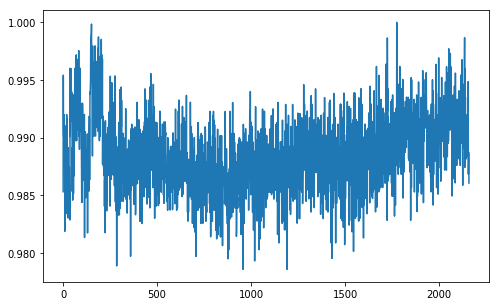

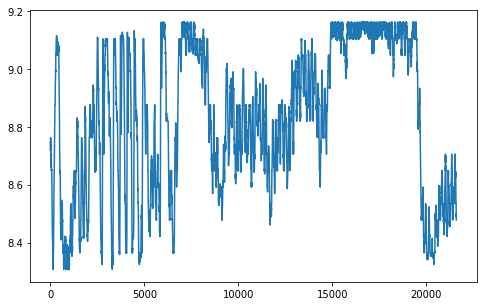

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

with h5py.File(fname, 'r') as f:
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value

p = ni['p polarization'][20:][::1000]
s = ni['s polarization'][20:][::1000]
p /= p.max()
s /= s.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(p)
ax.plot(s)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot((p+s)/(p+s).max())

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(mpb['seed power'])

In [8]:
from ctypes import *
from PyDAQmx.DAQmxTypes import *
from PyDAQmx import *
import PyDAQmx

def read_daq_continuous(rate, nrsamples, channels):
    # Declaration of variable passed by reference
    taskHandle = TaskHandle()
    read = int32()

    # DAQmx Configure Code
    DAQmxCreateTask("",byref(taskHandle))
    DAQmxCreateAIVoltageChan(taskHandle,"Dev1/ai1, Dev1/ai3","",DAQmx_Val_Cfg_Default,-1,1,DAQmx_Val_Volts,None)
    DAQmxCfgSampClkTiming(taskHandle,"",rate,DAQmx_Val_Rising,DAQmx_Val_ContSamps,nrsamples)
    return taskHandle

# Measurement 8
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
$\lambda$/2 plate to get equal power in both arms
12 hour measurement

In [15]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 8'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "half wave plate before polarizing beamsplitter after fiber of MPB amp to get equal power in both paths\n"+\
              "fiber -> lambda/2 -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*60*12)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

100%|█████████████████████████████████████████████████████████████████████████| 43200/43200 [12:00:01<00:00,  1.00s/it]


In [176]:
import pytz
from influxdb import InfluxDBClient
import datetime

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 8'

user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "returnTemperature", "supplyTemperature", "returnHumidity" FROM "autogen"."Vertiv" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
returnTemperature = []
supplyTemperature = []
returnHumidity = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    returnTemperature.append(p['returnTemperature'])
    supplyTemperature.append(p['supplyTemperature'])
    returnHumidity.append(p['returnHumidity'])

ch_units_vertiv = "s, C, C, %"
ch_names_vertiv = "time, return temperature, supply temperature, return humidity"
dtypes_vertiv = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_vertiv = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv))}"
               }
data_type_vertiv = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv)])
    
create_hdf_dset(fname, run_name, 'VERTIV', data_type_vertiv, attrs = attrs_vertiv)
save_to_hdf(fname, run_name, 'VERTIV', [np.array([timestamp, returnTemperature, supplyTemperature, returnHumidity])], data_type_vertiv)

In [177]:
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "bme280_temperature","bme280_humidity","bme280_pressure" FROM "autogen"."Lasertable 2" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
temperature = []
humidity = []
pressure = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    temperature.append(p['bme280_temperature'])
    humidity.append(p['bme280_humidity'])
    pressure.append(p['bme280_pressure'])

ch_units_lt2 = "s, C, C, %"
ch_names_lt2 = "time, temperature, humidity, pressure"
dtypes_lt2 = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_lt2 = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2))}"
               }
data_type_lt2 = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2)])
    
create_hdf_dset(fname, run_name, 'Lasertable2', data_type_lt2, attrs = attrs_lt2)
save_to_hdf(fname, run_name, 'Lasertable2', [np.array([timestamp, temperature, humidity, pressure])], data_type_lt2)

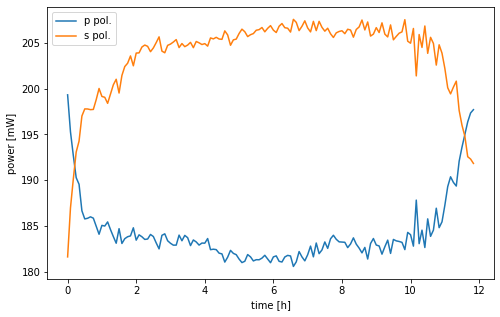

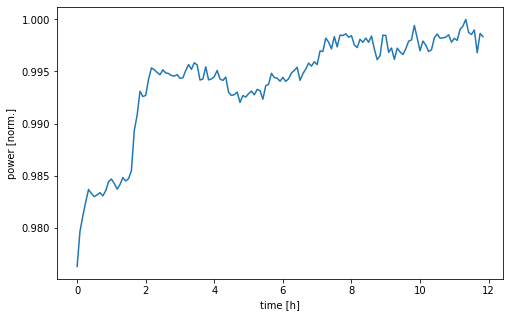

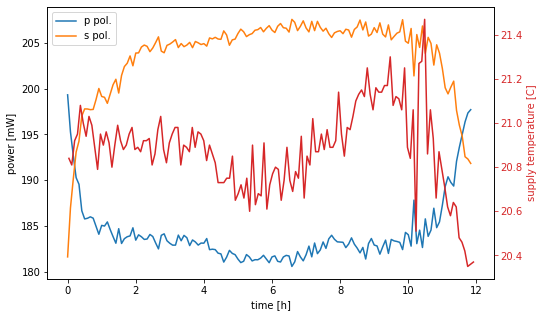

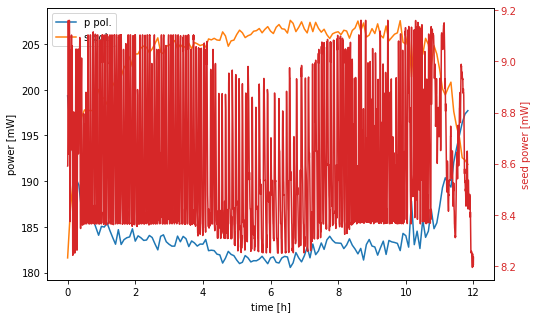

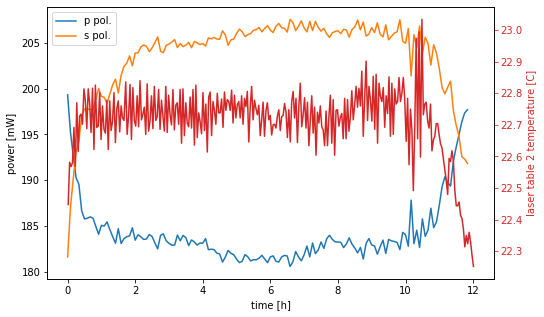

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np

def avg_array(arr, navg):
    lenarr = len(arr)//navg
    return np.mean(arr[:lenarr*navg].reshape(-1,navg), axis = 1)
    

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 8'

navg = 30000
navg_mpb = 10
navg_lt2 = 5
navg_vertiv = 10
tmax = 80000
time_factor = 3600 #convert to hour

# volt to mW
factorp = 1400/2
factors = 1800/2

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)*factorp
s = avg_array(s, navg)*factors
t = t[:len(p)]

# p /= (p+s).max()
# s /= (p+s).max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax.legend()

fig.savefig('polarization_mpb.png', dpi = 300)


fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,(p+s)/(p+s).max())

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')

fig.savefig('polarization_sumbranches.png', dpi = 300)


# Graph with supply temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tvertiv/time_factor, stavg, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('supply temperature [C]', color = 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()

fig.savefig('polarization&supplytemp_mpb.png', dpi = 300)


# graph with seed power

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tmpb/time_factor, seedpower, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('seed power [mW]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()



# graph with laser table 2 temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
# ax1.plot(tlt2/time_factor, savgol_filter(lt2temperature, 15,3), 'C3')
ax1.plot(tlt2/time_factor, lt2temperature, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('laser table 2 temperature [C]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()


# Measurement 9
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
$\lambda$/2 plate to get equal power in both arms
24 hour measurement

In [17]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 9'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "half wave plate before polarizing beamsplitter after fiber of MPB amp to get equal power in both paths\n"+\
              "fiber -> lambda/2 -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*60*24)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

100%|█████████████████████████████████████████████████████████████████████████| 86400/86400 [24:00:01<00:00,  1.00it/s]


In [85]:
import pytz
from influxdb import InfluxDBClient
import datetime

user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "returnTemperature", "supplyTemperature", "returnHumidity" FROM "autogen"."Vertiv" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
returnTemperature = []
supplyTemperature = []
returnHumidity = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    returnTemperature.append(p['returnTemperature'])
    supplyTemperature.append(p['supplyTemperature'])
    returnHumidity.append(p['returnHumidity'])

ch_units_vertiv = "s, C, C, %"
ch_names_vertiv = "time, return temperature, supply temperature, return humidity"
dtypes_vertiv = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_vertiv = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv))}"
               }
data_type_vertiv = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv)])
    
create_hdf_dset(fname, run_name, 'VERTIV2', data_type_vertiv, attrs = attrs_vertiv)
save_to_hdf(fname, run_name, 'VERTIV2', [np.array([timestamp, returnTemperature, supplyTemperature, returnHumidity])], data_type_vertiv)

In [88]:
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "bme280_temperature","bme280_humidity","bme280_pressure" FROM "autogen"."Lasertable 2" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
temperature = []
humidity = []
pressure = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    temperature.append(p['bme280_temperature'])
    humidity.append(p['bme280_humidity'])
    pressure.append(p['bme280_pressure'])

ch_units_lt2 = "s, C, C, %"
ch_names_lt2 = "time, temperature, humidity, pressure"
dtypes_lt2 = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_lt2 = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2))}"
               }
data_type_lt2 = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2)])
    
create_hdf_dset(fname, run_name, 'Lasertable2', data_type_lt2, attrs = attrs_lt2)
save_to_hdf(fname, run_name, 'Lasertable2', [np.array([timestamp, temperature, humidity, pressure])], data_type_lt2)

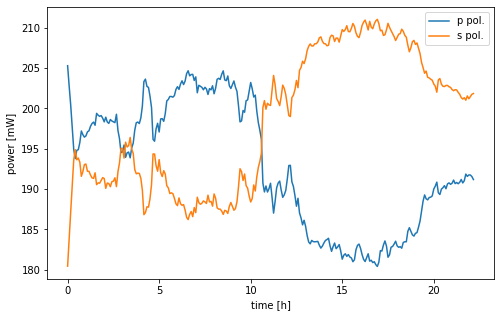

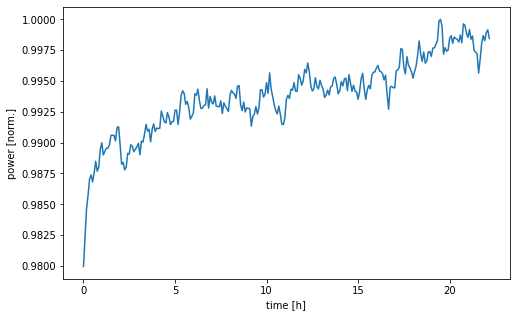

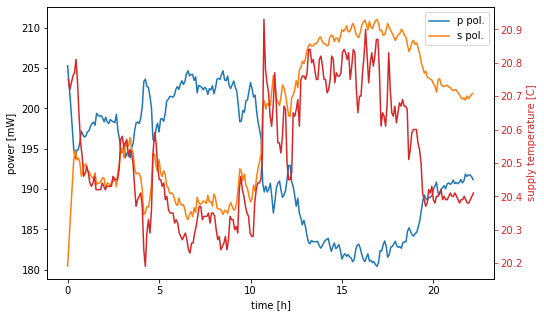

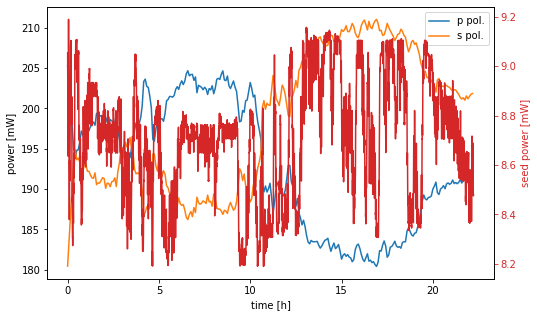

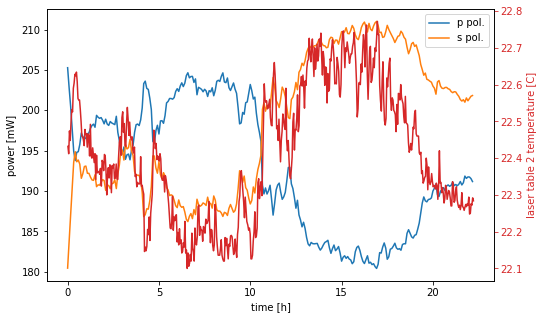

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 9'

navg = 30000
navg_mpb = 10
navg_lt2 = 5
navg_vertiv = 10
tmax = 80000
time_factor = 3600 #convert to hour

# volt to mW
factorp = 1400/2
factors = 1800/2

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV2'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)*factorp
s = avg_array(s, navg)*factors
t = t[:len(p)]

# p /= (p+s).max()
# s /= (p+s).max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax.legend()

fig.savefig('polarization_mpb.png', dpi = 300)


fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,(p+s)/(p+s).max())

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')


# Graph with supply temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tvertiv/time_factor, stavg, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('supply temperature [C]', color = 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()

fig.savefig('polarization&supplytemp_mpb.png', dpi = 300)


# graph with seed power

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tmpb/time_factor, seedpower, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('seed power [mW]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()



# graph with laser table 2 temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
# ax1.plot(tlt2/time_factor, savgol_filter(lt2temperature, 15,3), 'C3')
ax1.plot(tlt2/time_factor, lt2temperature, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('laser table 2 temperature [C]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()

fig.savefig('polarization&lasertable2temp.png', dpi = 300)

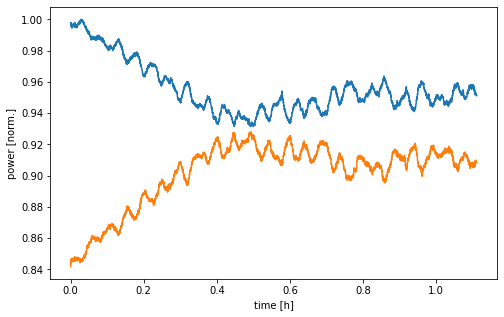

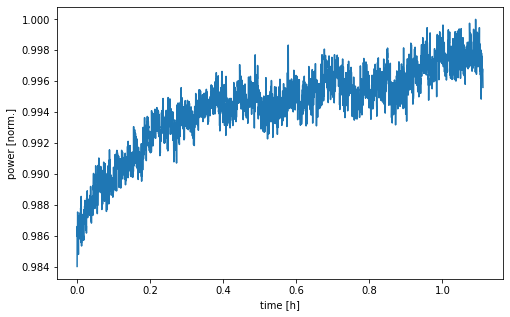

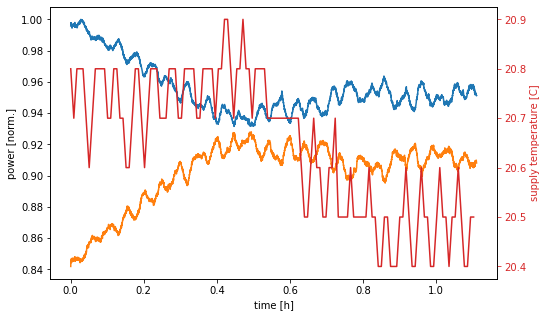

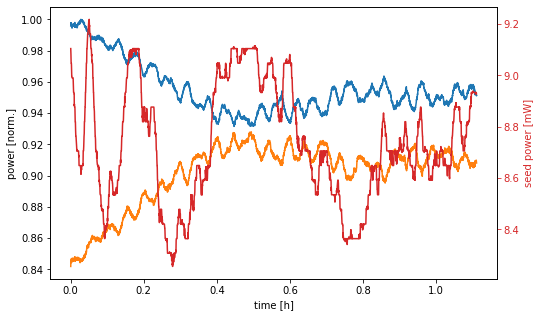

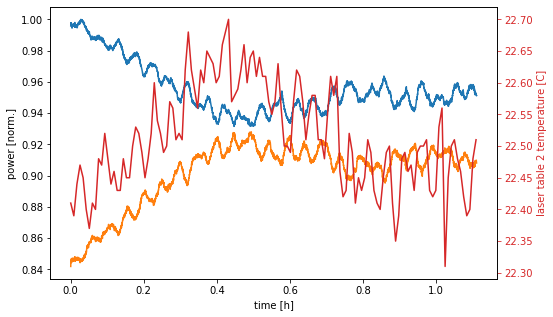

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 9'
navg = 100
navg_mpb = 1
navg_lt2 = 1 
navg_vertiv = 1
tmax = 4000
time_factor = 3600 #convert to hour

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV2'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)
s = avg_array(s, navg)
t = t[:len(p)]

p /= p.max()
s /= s.max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)
ax.plot(t/time_factor,s)

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,(p+s)/(p+s).max())

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')


# Graph with supply temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)
ax.plot(t/time_factor,s)

ax1 = ax.twinx()
ax1.plot(tvertiv/time_factor, stavg, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')
ax1.set_ylabel('supply temperature [C]', color = 'C3')
ax1.tick_params(axis='y', colors='C3')



# graph with seed power

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)
ax.plot(t/time_factor,s)

ax1 = ax.twinx()
ax1.plot(tmpb/time_factor, seedpower, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')
ax1.set_ylabel('seed power [mW]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')



# graph with laser table 2 temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)
ax.plot(t/time_factor,s)

ax1 = ax.twinx()
# ax1.plot(tlt2/time_factor, savgol_filter(lt2temperature, 15,3), 'C3')
ax1.plot(tlt2/time_factor, lt2temperature, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')
ax1.set_ylabel('laser table 2 temperature [C]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')

# Measurement 10
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
removed $\lambda$/2 plate
5 minute measurement

In [124]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 10'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "polarizing beamsplitter after fiber of MPB amp\n"+\
              "fiber -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*5)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [05:00<00:00,  1.00s/it]


In [126]:
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "bme280_temperature","bme280_humidity","bme280_pressure" FROM "autogen"."Lasertable 2" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
temperature = []
humidity = []
pressure = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    temperature.append(p['bme280_temperature'])
    humidity.append(p['bme280_humidity'])
    pressure.append(p['bme280_pressure'])

ch_units_lt2 = "s, C, C, %"
ch_names_lt2 = "time, temperature, humidity, pressure"
dtypes_lt2 = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_lt2 = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2))}"
               }
data_type_lt2 = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2)])
    
create_hdf_dset(fname, run_name, 'Lasertable2', data_type_lt2, attrs = attrs_lt2)
save_to_hdf(fname, run_name, 'Lasertable2', [np.array([timestamp, temperature, humidity, pressure])], data_type_lt2)

In [127]:
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "returnTemperature", "supplyTemperature", "returnHumidity" FROM "autogen"."Vertiv" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
returnTemperature = []
supplyTemperature = []
returnHumidity = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    returnTemperature.append(p['returnTemperature'])
    supplyTemperature.append(p['supplyTemperature'])
    returnHumidity.append(p['returnHumidity'])

ch_units_vertiv = "s, C, C, %"
ch_names_vertiv = "time, return temperature, supply temperature, return humidity"
dtypes_vertiv = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_vertiv = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv))}"
               }
data_type_vertiv = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv)])
    
create_hdf_dset(fname, run_name, 'VERTIV', data_type_vertiv, attrs = attrs_vertiv)
save_to_hdf(fname, run_name, 'VERTIV', [np.array([timestamp, returnTemperature, supplyTemperature, returnHumidity])], data_type_vertiv)

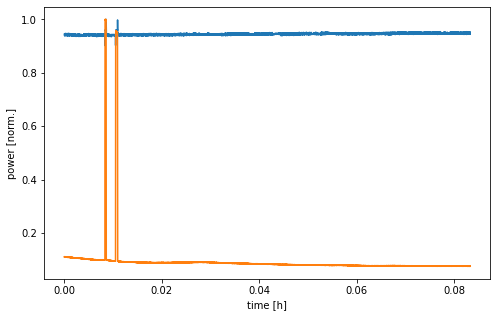

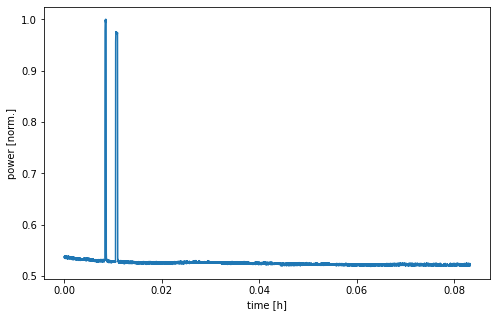

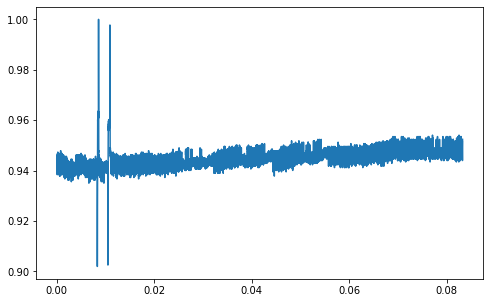

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 10'
navg = 1
navg_mpb = 1
navg_lt2 = 1
navg_vertiv = 1
tmax = 80000
time_factor = 3600 #convert to hour

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)
s = avg_array(s, navg)
t = t[:len(p)]

p /= p.max()
s /= s.max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)
ax.plot(t/time_factor,s)

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,(p+s)/(p+s).max())

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)

# Measurement 11
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
removed $\lambda$/2 plate  
2 hour measurement

In [132]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 11'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "polarizing beamsplitter after fiber of MPB amp\n"+\
              "fiber -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*60*2)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()

100%|████████████████████████████████████████████████████████████████████████████| 7200/7200 [2:00:00<00:00,  1.00s/it]


In [133]:
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "bme280_temperature","bme280_humidity","bme280_pressure" FROM "autogen"."Lasertable 2" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
temperature = []
humidity = []
pressure = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    temperature.append(p['bme280_temperature'])
    humidity.append(p['bme280_humidity'])
    pressure.append(p['bme280_pressure'])

ch_units_lt2 = "s, C, C, %"
ch_names_lt2 = "time, temperature, humidity, pressure"
dtypes_lt2 = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_lt2 = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2))}"
               }
data_type_lt2 = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2)])
    
create_hdf_dset(fname, run_name, 'Lasertable2', data_type_lt2, attrs = attrs_lt2)
save_to_hdf(fname, run_name, 'Lasertable2', [np.array([timestamp, temperature, humidity, pressure])], data_type_lt2)

In [134]:
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "returnTemperature", "supplyTemperature", "returnHumidity" FROM "autogen"."Vertiv" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
returnTemperature = []
supplyTemperature = []
returnHumidity = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    returnTemperature.append(p['returnTemperature'])
    supplyTemperature.append(p['supplyTemperature'])
    returnHumidity.append(p['returnHumidity'])

ch_units_vertiv = "s, C, C, %"
ch_names_vertiv = "time, return temperature, supply temperature, return humidity"
dtypes_vertiv = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_vertiv = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv))}"
               }
data_type_vertiv = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv)])
    
create_hdf_dset(fname, run_name, 'VERTIV', data_type_vertiv, attrs = attrs_vertiv)
save_to_hdf(fname, run_name, 'VERTIV', [np.array([timestamp, returnTemperature, supplyTemperature, returnHumidity])], data_type_vertiv)

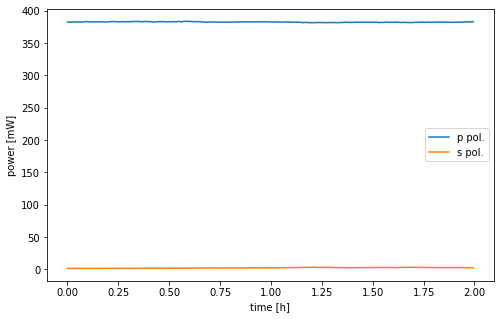

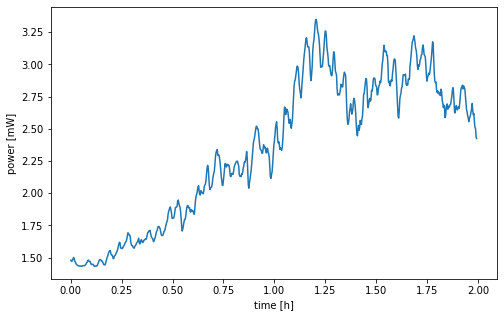

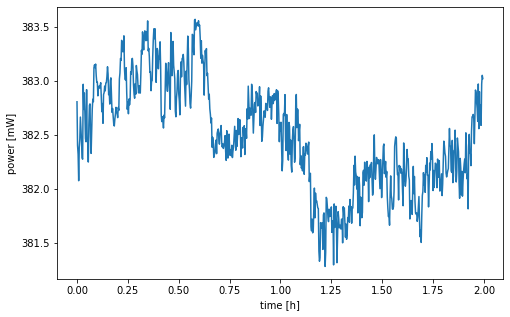

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 11'

navg = 1000
navg_mpb = 1
navg_lt2 = 1
navg_vertiv = 1
tmax = 80000
time_factor = 3600 #convert to hour

# volt to mW
factorp = 1400/2
factors = 18/2

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)*factorp
s = avg_array(s, navg)*factors
t = t[:len(p)]

# p /= (p+s).max()
# s /= (p+s).max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax.legend()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')

fig.savefig('polarization_nolambda2.png', dpi = 300)

# Measurement 12
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
removed $\lambda$/2 plate  
30 minute measurement

In [ ]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 12'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "polarizing beamsplitter after fiber of MPB amp\n"+\
              "fiber -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*30)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "bme280_temperature","bme280_humidity","bme280_pressure" FROM "autogen"."Lasertable 2" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
temperature = []
humidity = []
pressure = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    temperature.append(p['bme280_temperature'])
    humidity.append(p['bme280_humidity'])
    pressure.append(p['bme280_pressure'])

ch_units_lt2 = "s, C, C, %"
ch_names_lt2 = "time, temperature, humidity, pressure"
dtypes_lt2 = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_lt2 = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2))}"
               }
data_type_lt2 = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2)])
    
create_hdf_dset(fname, run_name, 'Lasertable2', data_type_lt2, attrs = attrs_lt2)
save_to_hdf(fname, run_name, 'Lasertable2', [np.array([timestamp, temperature, humidity, pressure])], data_type_lt2)

user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "returnTemperature", "supplyTemperature", "returnHumidity" FROM "autogen"."Vertiv" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
returnTemperature = []
supplyTemperature = []
returnHumidity = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    returnTemperature.append(p['returnTemperature'])
    supplyTemperature.append(p['supplyTemperature'])
    returnHumidity.append(p['returnHumidity'])

ch_units_vertiv = "s, C, C, %"
ch_names_vertiv = "time, return temperature, supply temperature, return humidity"
dtypes_vertiv = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_vertiv = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv))}"
               }
data_type_vertiv = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv)])
    
create_hdf_dset(fname, run_name, 'VERTIV', data_type_vertiv, attrs = attrs_vertiv)
save_to_hdf(fname, run_name, 'VERTIV', [np.array([timestamp, returnTemperature, supplyTemperature, returnHumidity])], data_type_vertiv)

Text(0, 0.5, 'power [mW]')

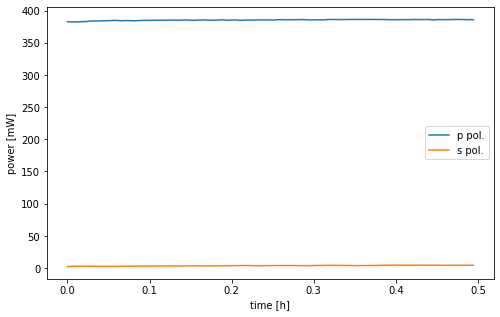

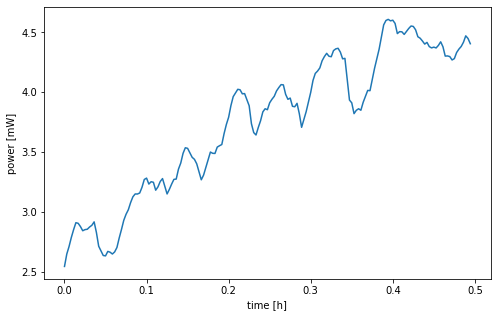

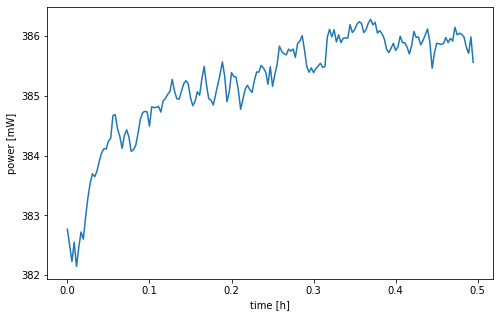

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 12'

navg = 1000
navg_mpb = 1
navg_lt2 = 1
navg_vertiv = 1
tmax = 80000
time_factor = 3600 #convert to hour

# volt to mW
factorp = 1400/2
factors = 18/2

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)*factorp
s = avg_array(s, navg)*factors
t = t[:len(p)]

# p /= (p+s).max()
# s /= (p+s).max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax.legend()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')

# Measurement 13
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
removed $\lambda$/2 plate  
12 hour measurement

In [ ]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 13'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "polarizing beamsplitter after fiber of MPB amp\n"+\
              "fiber -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*60*12)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "bme280_temperature","bme280_humidity","bme280_pressure" FROM "autogen"."Lasertable 2" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
temperature = []
humidity = []
pressure = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    temperature.append(p['bme280_temperature'])
    humidity.append(p['bme280_humidity'])
    pressure.append(p['bme280_pressure'])

ch_units_lt2 = "s, C, C, %"
ch_names_lt2 = "time, temperature, humidity, pressure"
dtypes_lt2 = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_lt2 = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2))}"
               }
data_type_lt2 = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2)])
    
create_hdf_dset(fname, run_name, 'Lasertable2', data_type_lt2, attrs = attrs_lt2)
save_to_hdf(fname, run_name, 'Lasertable2', [np.array([timestamp, temperature, humidity, pressure])], data_type_lt2)

user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "returnTemperature", "supplyTemperature", "returnHumidity" FROM "autogen"."Vertiv" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
returnTemperature = []
supplyTemperature = []
returnHumidity = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    returnTemperature.append(p['returnTemperature'])
    supplyTemperature.append(p['supplyTemperature'])
    returnHumidity.append(p['returnHumidity'])

ch_units_vertiv = "s, C, C, %"
ch_names_vertiv = "time, return temperature, supply temperature, return humidity"
dtypes_vertiv = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_vertiv = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv))}"
               }
data_type_vertiv = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv)])
    
create_hdf_dset(fname, run_name, 'VERTIV', data_type_vertiv, attrs = attrs_vertiv)
save_to_hdf(fname, run_name, 'VERTIV', [np.array([timestamp, returnTemperature, supplyTemperature, returnHumidity])], data_type_vertiv)

Text(0, 0.5, 'power [mW]')

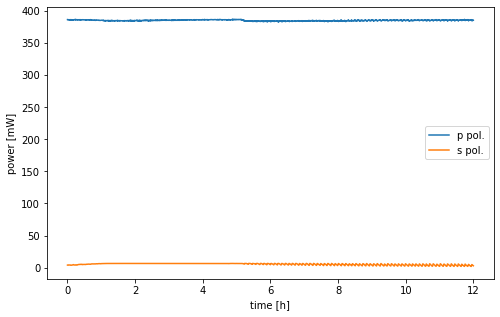

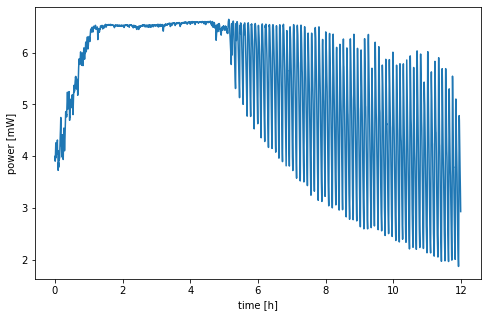

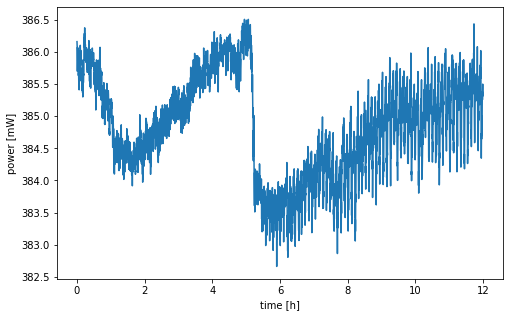

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 13'

navg = 1000
navg_mpb = 1
navg_lt2 = 1
navg_vertiv = 1
tmax = 80000
time_factor = 3600 #convert to hour

# volt to mW
factorp = 1400/2
factors = 18/2

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)*factorp
s = avg_array(s, navg)*factors
t = t[:len(p)]

# p /= (p+s).max()
# s /= (p+s).max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax.legend()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p)

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')

# Measurement 14
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
removed $\lambda$/2 plate  
rotated polarizing beamsplitter to get equal power in both branches  
12 hour measurement

In [ ]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 14'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "polarizing beamsplitter after fiber of MPB amp\n"+\
              "rotated polarizing beamsplitter to get equal power in both branches"+\
              "fiber -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*60*12)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "bme280_temperature","bme280_humidity","bme280_pressure" FROM "autogen"."Lasertable 2" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
temperature = []
humidity = []
pressure = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    temperature.append(p['bme280_temperature'])
    humidity.append(p['bme280_humidity'])
    pressure.append(p['bme280_pressure'])

ch_units_lt2 = "s, C, C, %"
ch_names_lt2 = "time, temperature, humidity, pressure"
dtypes_lt2 = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_lt2 = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2))}"
               }
data_type_lt2 = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2)])
    
create_hdf_dset(fname, run_name, 'Lasertable2', data_type_lt2, attrs = attrs_lt2)
save_to_hdf(fname, run_name, 'Lasertable2', [np.array([timestamp, temperature, humidity, pressure])], data_type_lt2)

user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "returnTemperature", "supplyTemperature", "returnHumidity" FROM "autogen"."Vertiv" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
returnTemperature = []
supplyTemperature = []
returnHumidity = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    returnTemperature.append(p['returnTemperature'])
    supplyTemperature.append(p['supplyTemperature'])
    returnHumidity.append(p['returnHumidity'])

ch_units_vertiv = "s, C, C, %"
ch_names_vertiv = "time, return temperature, supply temperature, return humidity"
dtypes_vertiv = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_vertiv = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv))}"
               }
data_type_vertiv = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv)])
    
create_hdf_dset(fname, run_name, 'VERTIV', data_type_vertiv, attrs = attrs_vertiv)
save_to_hdf(fname, run_name, 'VERTIV', [np.array([timestamp, returnTemperature, supplyTemperature, returnHumidity])], data_type_vertiv)

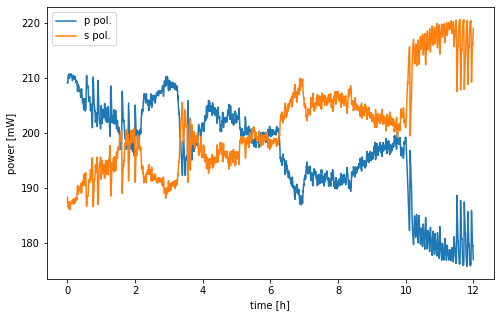

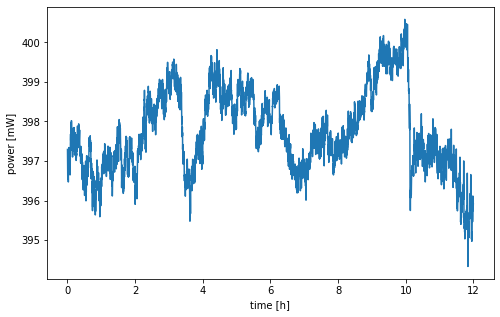

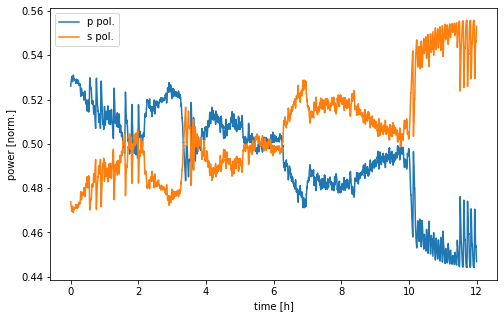

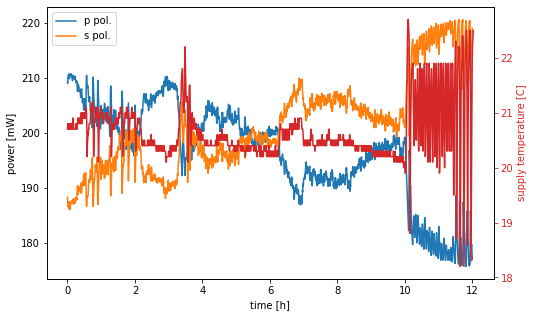

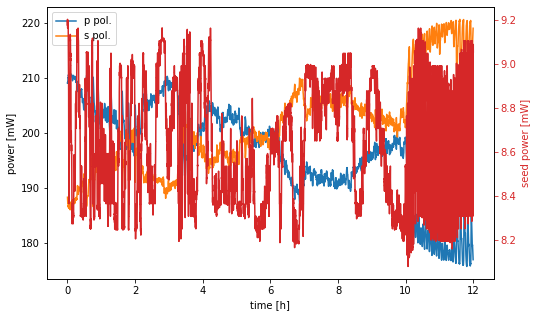

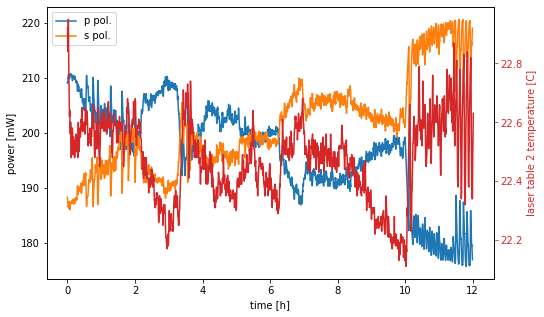

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 14'

navg = 1000
navg_mpb = 1
navg_lt2 = 1
navg_vertiv = 1
tmax = 80000
time_factor = 3600 #convert to hour

# volt to mW
factorp = 1400/2
factors = 1800/2

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)*factorp
s = avg_array(s, navg)*factors
t = t[:len(p)]

# p /= (p+s).max()
# s /= (p+s).max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax.legend()

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p+s)

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p/(p+s), label = 'p pol.')
ax.plot(t/time_factor,s/(p+s), label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [norm.]')
ax.legend()

# Graph with supply temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tvertiv/time_factor, stavg, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('supply temperature [C]', color = 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()


# graph with seed power

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tmpb/time_factor, seedpower, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('seed power [mW]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()



# graph with laser table 2 temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tlt2/time_factor, lt2temperature, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('laser table 2 temperature [C]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()

# Measurement 15
- s polarization S130C Thorlabs power sensor
- p polarization S121C Thorlabs power sensor
stabilization on @400mW  
removed $\lambda$/2 plate  
rotated polarizing beamsplitter to get equal power in both branches  
7 hour measurement

In [ ]:
import time
from tqdm import tqdm

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 15'
description = "Measurement of polarization change of MPB Communications AMP + SHG as a function of time\n"+\
              "polarizing beamsplitter after fiber of MPB amp\n"+\
              "rotated polarizing beamsplitter to get equal power in both branches"+\
              "fiber -> pol. bs"+\
              "s polarization : S130C Thorlabs Sensor\n"+\
              "p polarization : S121C Thorlabs sensor"
ch_units_ni = "V, V"
ch_names_ni = "p polarization, s polarization"
dtypes_ni = ['np.float', 'np.float']

ch_units_mpb = "s, mW, mW, C, mA"
ch_names_mpb = "time, seed power, output power, SHG temperature, LD3 current"
dtypes_mpb = ['float', 'np.float', 'np.float', 'np.float', 'np.float']

samples = 100
rate = 100
channels = 2
measurement_time = int(60*60*7)

mpb = MPB('COM1')

data_sec = np.ndarray((samples*channels,), dtype=np.float64)

read = PyDAQmx.int32()

taskHandle = read_daq_continuous(rate, samples, channels)
data_type_ni = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_ni.split(','), dtypes_ni)])
data_type_mpb = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb)])

attrs_measurement = { "description": description}
attrs_ni = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_ni.split(','), dtypes_ni))}",
             "rate": rate,
           }
attrs_mpb = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_mpb.split(','), dtypes_mpb))}"
           }
create_hdf_grp(fname, run_name, attrs_measurement)
create_hdf_dset(fname, run_name, 'NI', data_type_ni, attrs = attrs_ni)
create_hdf_dset(fname, run_name, 'MPB', data_type_mpb, attrs = attrs_mpb)

# Initializing MPB Laser
mpb.SetPower(0, 400)
mpb.PowerEnable(1)
mpb.SetLDEnable(1)
time.sleep(30)

DAQmxStartTask(taskHandle)
try:
    for i in tqdm(range(measurement_time)):
        data_bulk = []
        DAQmxReadAnalogF64(taskHandle,samples,samples,DAQmx_Val_GroupByChannel,data_sec,samples*channels,byref(read),None)
        data_mpb = [time.time(), float(mpb.Power(3)), float(mpb.Power(0)), float(mpb.GetSHGTemperature()), float(mpb.LDCurrent(3))]
        data_mpb = np.array([[d] for d in data_mpb])
        data_bulk.append(data_sec.reshape(channels,samples))
        save_to_hdf(fname, run_name, 'NI', data_bulk, data_type_ni)
        save_to_hdf(fname, run_name, 'MPB', [data_mpb], data_type_mpb)
        data_bulk = []
except KeyboardInterrupt:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise(Key)
except Exception as e:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    raise e
finally:
    DAQmxStopTask(taskHandle)
    DAQmxClearTask(taskHandle)
    mpb.SetLDEnable(0)
    mpb.ser.close()
    
user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "bme280_temperature","bme280_humidity","bme280_pressure" FROM "autogen"."Lasertable 2" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
temperature = []
humidity = []
pressure = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    temperature.append(p['bme280_temperature'])
    humidity.append(p['bme280_humidity'])
    pressure.append(p['bme280_pressure'])

ch_units_lt2 = "s, C, C, %"
ch_names_lt2 = "time, temperature, humidity, pressure"
dtypes_lt2 = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_lt2 = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2))}"
               }
data_type_lt2 = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_lt2.split(','), dtypes_lt2)])
    
create_hdf_dset(fname, run_name, 'Lasertable2', data_type_lt2, attrs = attrs_lt2)
save_to_hdf(fname, run_name, 'Lasertable2', [np.array([timestamp, temperature, humidity, pressure])], data_type_lt2)

user = 'admin'
password = 'molecules'
host = '172.28.82.114'
port = '8086'
client = InfluxDBClient(host, port, user, password)
client.switch_database('environment')

with h5py.File(fname, 'r') as f:
    mpb = f[run_name]['MPB'].value

tstart = datetime.datetime.fromtimestamp(mpb['time'][0], tz = pytz.UTC)-datetime.timedelta(seconds = 60)
tstop = datetime.datetime.fromtimestamp(mpb['time'][-1], tz = pytz.UTC)+datetime.timedelta(seconds = 60)
tstart = tstart.isoformat("T").split("+")[0]+"Z"
tstop = tstop.isoformat("T").split("+")[0]+"Z"

query = f'SELECT "returnTemperature", "supplyTemperature", "returnHumidity" FROM "autogen"."Vertiv" WHERE time >= \'{tstart}\' AND time <=\'{tstop}\''

vertiv = client.query(query, epoch = 'u')

timestamp = []
returnTemperature = []
supplyTemperature = []
returnHumidity = []
for p in vertiv.get_points():
    timestamp.append(p['time']/1e6)
    returnTemperature.append(p['returnTemperature'])
    supplyTemperature.append(p['supplyTemperature'])
    returnHumidity.append(p['returnHumidity'])

ch_units_vertiv = "s, C, C, %"
ch_names_vertiv = "time, return temperature, supply temperature, return humidity"
dtypes_vertiv = ['float', 'np.float', 'np.float', 'np.float']
    
attrs_vertiv = { "units": f"{dict((name, ty) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv))}"
               }
data_type_vertiv = np.dtype([(name.strip(), eval(ty)) for name, ty in zip(ch_names_vertiv.split(','), dtypes_vertiv)])
    
create_hdf_dset(fname, run_name, 'VERTIV', data_type_vertiv, attrs = attrs_vertiv)
save_to_hdf(fname, run_name, 'VERTIV', [np.array([timestamp, returnTemperature, supplyTemperature, returnHumidity])], data_type_vertiv)

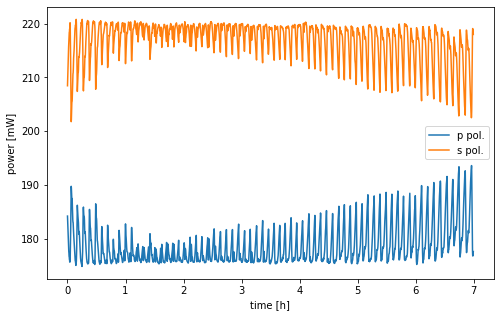

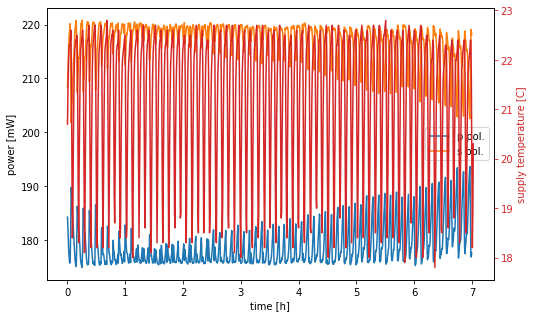

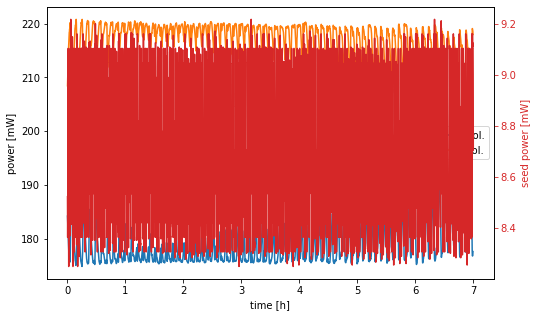

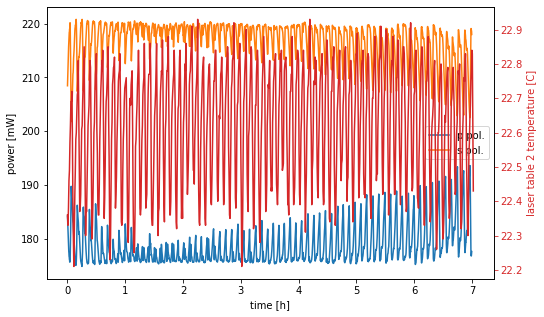

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

fname = 'mpb_polarization_stability.hdf5'
run_name = 'measurement 15'

navg = 1000
navg_mpb = 1
navg_lt2 = 1
navg_vertiv = 1
tmax = 80000
time_factor = 3600 #convert to hour

# volt to mW
factorp = 1400/2
factors = 1800/2

with h5py.File(fname, 'r') as f:
    rate = f[run_name]['NI'].attrs['rate']
    ni = f[run_name]['NI'].value
    mpb = f[run_name]['MPB'].value
    lt2 = f[run_name]['Lasertable2'].value
    vertiv = f[run_name]['VERTIV'].value
    
t = mpb['time'][0]+np.arange(0,len(ni)//(rate),0.01*navg)    
t -= t[0]
p = ni['p polarization'][20:]
s = ni['s polarization'][20:]

p = avg_array(p, navg)*factorp
s = avg_array(s, navg)*factors
t = t[:len(p)]

# p /= (p+s).max()
# s /= (p+s).max()

# averaging vertiv data
stavg = avg_array(vertiv['supply temperature'], navg_vertiv)
tvertiv = avg_array(vertiv['time'], navg_vertiv)-vertiv['time'][0]

# averaging mpb data
tmpb = avg_array(mpb['time'], navg_mpb)-mpb['time'][0]
seedpower = avg_array(mpb['seed power'],navg_mpb)

# averaging lt2 data
tlt2 = avg_array(lt2['time'], navg_lt2)-lt2['time'][0]
lt2temperature = avg_array(lt2['temperature'], navg_lt2)


# masking all data to tmax
mask = t <= tmax
t = t[mask]
s = s[mask]
p = p[mask]

masklt2 = lt2['time']-lt2['time'][0] <= tmax
maskmpb = tmpb <= tmax
maskvertiv = tvertiv <= tmax
masklt2 = tlt2 <= tmax

tvertiv = tvertiv[maskvertiv]
stavg = stavg[maskvertiv]

tmpb = tmpb[maskmpb]
seedpower = seedpower[maskmpb]

tlt2 = tlt2[masklt2]
lt2temperature = lt2temperature[masklt2]

# graph with only polarizations

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax.legend()

# Graph with supply temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tvertiv/time_factor, stavg, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('supply temperature [C]', color = 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()


# graph with seed power

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tmpb/time_factor, seedpower, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('seed power [mW]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()



# graph with laser table 2 temperature

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t/time_factor,p, label = 'p pol.')
ax.plot(t/time_factor,s, label = 's pol.')

ax1 = ax.twinx()
ax1.plot(tlt2/time_factor, lt2temperature, 'C3')

ax.set_xlabel('time [h]')
ax.set_ylabel('power [mW]')
ax1.set_ylabel('laser table 2 temperature [C]', color= 'C3')
ax1.tick_params(axis='y', colors='C3')
ax.legend()